Runned by COLAB & Adjusted the ipynb to be able to runned by jupyterlab

Reference: https://www.youtube.com/watch?v=_eSGWNqKeeY

# SETUP(When Using COLAB)

In [1]:
import tensorflow as tf

# Get the GPU Device name
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found.')


SystemError: GPU device not found.

torch가 GPU를 사용하도록 하려면, GPU를 확인하고 device로 직접 지정해야 한다 나중에 training loop를 돌 때 데이터들(Tensors)을 해당 GPU에 로드할 것이다

In [2]:
import torch
# 활용 가능한 GPU가 있다면
if torch.cuda.is_available():
    # 파이토치에게 GPU를 이용하도록 명령
    device = torch.device('cuda')
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU: ', torch.cuda.get_device_name(0))
else:
    print('No GPU available. Using the CPU instead')
    device = torch.device('cpu')


No GPU available. Using the CPU instead


C:\Users\SGI\anaconda3\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


# 라이브러리 import 및 데이터 Load

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
import re

In [7]:
path = "data"
train_df = pd.read_csv(path + "/train.csv")
test_df = pd.read_csv(path + "/test.csv")
sample_submission = pd.read_csv(path + '/sample_submission.csv')

print(' Done.')

 Done.


# Train 데이터셋 전처리(1)- 누락값 제거 및 깔끔한 Corpus만들기

In [8]:
# Display the first five rows of the table.
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [9]:
# 데이터 전처리 -> tweet-preprocessor 이용
# !pip install tweet-preprocessor

*   tweet-preprocessor

  *   URLs
  *   Mentions
  *   Reserved words (RT, FAV)
      *  RT: Retweet의 약자
      *  FAV:  Favorite의 약자
  *   Emojis
  *   Smileys
  *   JSON and .txt file support

In [12]:
import preprocessor 
from wordcloud import STOPWORDS
from nltk.stem import WordNetLemmatizer
import nltk
# nltk.download('wordnet')
# nltk.download('punkt')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\SGI\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\SGI\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [13]:
stop = set(STOPWORDS).union(set(['FAV' , 'RT']))  ## .union() =  합집합
lemma = WordNetLemmatizer()  ## NLTK에서는 표제어(단어의 뿌리) 추출을 위한 도구인 WordNetLemmatizer를 지원
preprocessor.set_options(preprocessor.OPT.URL, preprocessor.OPT.MENTION, preprocessor.OPT.NUMBER, preprocessor.OPT.RESERVED)  ## OPT = option(https://pypi.org/project/tweet-preprocessor/)

def clean(text):   
    text = preprocessor.clean(text)
    text = re.sub(r'[^\w\s]','',text)
    stop_free = " ".join([i for i in text.split(' ') if (i not in stop)])
    normalized = " ".join(lemma.lemmatize(word) for word in stop_free.split())
    return normalized

In [14]:
# 정제된 데이터
train_df.text = train_df.text.apply(clean)

In [15]:
text = train_df.text
text

0         Our Deeds Reason earthquake May ALLAH Forgive u
1                   Forest fire near La Ronge Sask Canada
2       All resident asked shelter place notified offi...
3       people receive wildfire evacuation order Calif...
4       Just got sent photo Ruby Alaska smoke wildfire...
                              ...                        
7608    Two giant crane holding bridge collapse nearby...
7609    The control wild fire California even Northern...
7610                    M194 0104 UTC5km S Volcano Hawaii
7611    Police investigating ebike collided car Little...
7612    The Latest More Homes Razed Northern Californi...
Name: text, Length: 7613, dtype: object

### 간단한 EDA:단어별 재난 연관률

In [16]:
keywords_targets = train_df.groupby('keyword')['target'].mean()

In [17]:
keywords_targets

keyword
ablaze                 0.361111
accident               0.685714
aftershock             0.000000
airplane%20accident    0.857143
ambulance              0.526316
                         ...   
wounded                0.702703
wounds                 0.303030
wreck                  0.189189
wreckage               1.000000
wrecked                0.076923
Name: target, Length: 221, dtype: float64

In [18]:
k_t_corelation = pd.DataFrame(keywords_targets)

In [19]:
k_t_corelation = k_t_corelation.sort_values(by='target', ascending=False)
k_t_corelation.head()

,target
keyword,
debris,1.000000
wreckage,1.000000
derailment,1.000000
outbreak,0.975000
oil%20spill,0.973684


In [20]:
keywords_targets.shape

(221,)

해당 단어 등장 대비 실제 재해 트윗인 비율을 기준으로 221개의 keyword 중, 상위 5개 단어를 뽑아봄: 특히 debris, wreckage, derailment 이 3개 단어는 등장했을 경우 모두 재난 상황을 지칭한 경우였음

#### 재난 상황 트윗 임의로 10개 뽑아 관찰

In [21]:
import textwrap
import random

# Wrap text to 80 characters
wrapper = textwrap.TextWrapper(width = 80)

# filter to just the 'Disaster' comments
disaster_examples = train_df.query('target == 1')['text']

# Randomly choose some examples
for i in range(10):
    j = random.choice(disaster_examples.index)
    print('')
    print(wrapper.fill(disaster_examples[j]))
    print('')


See Aug PoconoRecord How Many Households Have Emergency Plan


Usama bin Ladins family dead airplane crash Naturally accident


South Sac I5 S I5 S rd Ave Ofr Trfc CollisionNo Inj


Firefighters Connecticut headed California fight wild fire


Seven Chinese Christians Are Detained Amid Widespread Anger Over Cross
Demolition


patrickjbutler Excellent damiengayle eyewitness account Kids Company closure You
drop bomb expectÛ_


Someone teaching obedience will obliterate trial life trying sell used car
Jesuss life blow theory


I totally agree They rape kill destroy leave land desolate Action need happen
swarm swell


ok peace I hope I fall cliff along dignity


Theres fire Catalinas Looks kinda cool This picture doesnt justice



In [22]:
# What percentage of the comments are disaster tweets?
total_tweets = len(train_df)
num_disasters = len(train_df.query('target == 1'))

print('{:,}개의 트윗 중 {:,}개는 재난 관련 트윗임({:.2%}).'.format(total_tweets, num_disasters, num_disasters/total_tweets))

7,613개의 트윗 중 3,271개는 재난 관련 트윗임(42.97%).


keyword == NaN인 행들을 날린 train_df는 재난 트윗과 재난이 아닌 트윗이 꽤 균형 있게 존재한다.

다양한 python format 형식들: https://www.w3schools.com/python/ref_string_format.asp

In [23]:
# 전처리된 train_df의 text들 중 가장 긴 tweet의 단어 개수와 가장 짧은 단어 개수 출력
total_mx = max([len(length) for length in train_df.text])
total_mn = min([len(length) for length in train_df.text])
disaster_mx = max([len(length) for length in train_df.query('target == 1')])
disaster_mn = min([len(length) for length in train_df.query('target == 1')])

print('전체 tweets 중 최대 길이: {:>,}, 최소 길이 {:>,} \n재해 tweets 중 최대 길이: {}, 최소 길이 {}'.format(total_mx, total_mn, disaster_mx, disaster_mn))

전체 tweets 중 최대 길이: 138, 최소 길이 3 
재해 tweets 중 최대 길이: 8, 최소 길이 2


# Train 데이터셋 전처리(2)- Tokenizing

## BERT Input Length Limitation

In [24]:
# !pip install transformers

In [25]:
from transformers import BertTokenizer

print("Load Bert_Tokenizer...")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case = True)

Load Bert_Tokenizer...


BertTokenizer이 어떻게 작동되는지 살펴보기

In [26]:
import textwrap

# 첫 번째 텍스트 꺼내오기
sample_text = train_df.iloc[0].text

# Run the tokenizer to count up the number of tokens. The tokenizer will split the text into words, punctuations and subwords as needed
tokens = tokenizer.tokenize(sample_text)

print('train_df의 첫 번째 text에는 {:,}개의 WordPiece Tokens를 가지고 있다'.format(len(tokens)))
print('\nOriginal Text:\n')
print(wrapper.fill(sample_text))

train_df의 첫 번째 text에는 8개의 WordPiece Tokens를 가지고 있다

Original Text:

Our Deeds Reason earthquake May ALLAH Forgive u


In [27]:
# 토큰 리스트 출력
print('==== Tokens ====\n')
print(wrapper.fill(str(' '.join(tokens))))
print('')

==== Tokens ====

our deeds reason earthquake may allah forgive u



## 모든 트윗들 Bert 이용하여 Tokenize(Vectorization 포함)

In [28]:
import numpy as np

# 모든 문장 토크나이징 하고 id에 따라 분류하기
input_ids  = []

# 각 트윗의 토큰 개수 기록
token_len = []

print('Tokenizing Tweets...')

# 각 트윗 마다...
for tweet in train_df.text:
    # 진행 상황
    if ((len(input_ids) % 200) == 0):
        print(' Read {:,} tweets.'.format(len(input_ids)))
    
    # encode will
    # 1)트윗을 토크나이징하고, 
    # 2)[CLS]토큰을 시작 부분에, [SEP]토큰을 마지막 부분에 추가하고, 
    # 3)토큰을 해당 id에 매칭
    encoded_sent = tokenizer.encode(
        tweet, # Tweet to encode
        add_special_tokens = True,  # add_special_tokens: [CLS]와 [SEP]추가'
        # max_length = 512,  # Truncate all tweets
        # return_tensors = 'pt'  # Return pytorch tensors.
    ) 
    
    # encoded된 트윗을 리스트에 넣기
    input_ids.append(encoded_sent)
    
    # 각 트윗의 토큰 개수 기록
    token_len.append(len(encoded_sent))

print('DONE.')
print('{:>10} tweets'.format(len(input_ids)))



Tokenizing Tweets...
 Read 0 tweets.
 Read 200 tweets.
 Read 400 tweets.
 Read 600 tweets.
 Read 800 tweets.
 Read 1,000 tweets.
 Read 1,200 tweets.
 Read 1,400 tweets.
 Read 1,600 tweets.
 Read 1,800 tweets.
 Read 2,000 tweets.
 Read 2,200 tweets.
 Read 2,400 tweets.
 Read 2,600 tweets.
 Read 2,800 tweets.
 Read 3,000 tweets.
 Read 3,200 tweets.
 Read 3,400 tweets.
 Read 3,600 tweets.
 Read 3,800 tweets.
 Read 4,000 tweets.
 Read 4,200 tweets.
 Read 4,400 tweets.
 Read 4,600 tweets.
 Read 4,800 tweets.
 Read 5,000 tweets.
 Read 5,200 tweets.
 Read 5,400 tweets.
 Read 5,600 tweets.
 Read 5,800 tweets.
 Read 6,000 tweets.
 Read 6,200 tweets.
 Read 6,400 tweets.
 Read 6,600 tweets.
 Read 6,800 tweets.
 Read 7,000 tweets.
 Read 7,200 tweets.
 Read 7,400 tweets.
 Read 7,600 tweets.
DONE.
      7613 tweets


train_df에서 labels 추출한 뒤, 재난 관련 트윗과 재난 관련되지 않은 트윗의 분포 보기

In [29]:
labels = train_df.target.to_numpy().astype(int)

print('{:>7,} positive (is disaster tweet)'.format(np.sum(labels)))
print('{:>7,} negative (not disaster tweet)'.format(len(labels) - np.sum(labels)))

  3,271 positive (is disaster tweet)
  4,342 negative (not disaster tweet)


### 토큰 길이 분포에 따른 시각화

In [30]:
# 토큰나이징 된 train_df의 tweet들 중 가장 긴 tweet의 단어 개수와 가장 짧은 단어 개수 출력

print('전체 tweets 중 토큰 최대 개수: {:>,}, 최소 개수: {:>,}, 중간값: {:.0f}'.format(max(token_len), min(token_len), np.median(token_len)))

전체 tweets 중 토큰 최대 개수: 47, 최소 개수: 3, 중간값: 14


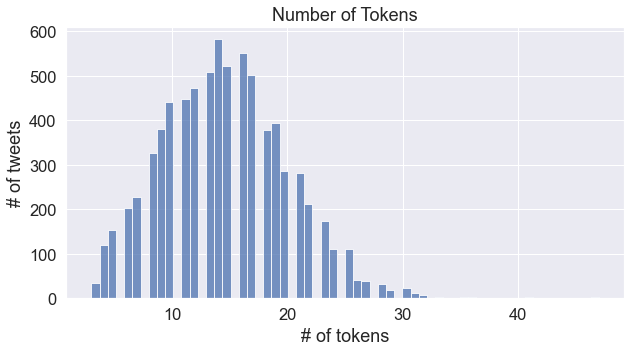

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.graph_objects as go
import plotly.express as px


sns.set(style = 'darkgrid')

# 플롯 크기랑 폰트 사이즈 키우기
sns.set(font_scale = 1.5)
plt.rcParams['figure.figsize'] = (10, 5)

# 트윗 토큰 개수에 따른 시각화
sns.histplot(token_len, kde = False)
plt.title("Number of Tokens")
plt.xlabel('# of tokens')
plt.ylabel('# of tweets')
plt.show()

트윗의 길이와 재난 관련 트윗일 확률 간에 상관 관계 확인

In [32]:
num_pos = 0
num_neg = 0
num_pos_residual = 0
num_neg_residual = 0

for i, l in enumerate(token_len):
    # 트윗의 개수가 30이상이라면(그래프 보고 대충 30~정도 토큰이면 긴 트윗에 속한다고 판단)
    if l >= 14: #중간값 기준
        # 해당 긴 트윗이 재난 관련 트윗인지 아닌지 판단하여 개수 세기
        if labels[l] == 1:
            num_pos += 1
        else:
            num_neg += 1
    else:
        if labels[l] == 1:
            num_pos_residual += 1
        else:
            num_neg_residual += 1
            
            
# 결과 보고
print("Among tweets that have over 30 tokens, {:,}({:.1%}) are disaster tweets.".format(num_pos, num_pos/(num_pos+num_neg)))
print("Among overall tweets, {:,}({:.1%}) are 'Disaster Tweets'.".format(num_pos+num_pos_residual, (num_pos+num_pos_residual)/len(token_len)))

Among tweets that have over 30 tokens, 598(13.9%) are disaster tweets.
Among overall tweets, 3,917(51.5%) are 'Disaster Tweets'.


트윗의 길이와 재난 트윗일 가능성은 역의 상관관계를 가지고 있다.(재난 상황이 일반적으로 긴박하기에 짧은 트윗으로 빠르게 정보를 공유하고자 하는 경향이 있어서 그런가?)

## 트윗들 Padding하기

In [33]:
### 트윗들 padding하기
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_LEN = 47 #트윗당 최대 토큰 개수로 맞춰서 누락되는 토큰 아예 없애기

print('\nPadding all tweets to %d values...' % MAX_LEN)
print('\nPadding Token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# input_ids에 담긴 트윗당 토큰들을 0으로 채워넣어 Max_len 크기로 패딩하기
input_ids = pad_sequences(input_ids, maxlen = MAX_LEN, dtype = 'long', value = 0, truncating = 'post', padding = 'post')
print('\nDONE.')


Padding all tweets to 47 values...

Padding Token: "[PAD]", ID: 0

DONE.


## Attention_Masks 만들기
Attention_mast의 역할: 실제 의미가 있는 토큰들만 따로 저장: 이후 tensor로 변환된 뒤 DataLoader에 담겨 BERT 훈련 모델에 입력값으로 들어감

In [34]:
attention_masks = []

# 각 트윗마다...
for sent in input_ids:
    # Attention Mask 만들기
    #  - token_id가 0이라면, 패딩이다. 마스크값에 0을 주고,
    #  - token_id가 >0이라면, 의미 있는 토큰이므로 마스크값에 1 주기!
    att_mask = [int(token_id>0) for token_id in sent]

    attention_masks.append(att_mask)

---

## 학습용 데이터 90%와 검증용 데이터 10%로 나누기

In [35]:
from sklearn.model_selection import train_test_split

# 훈련 90% 검증 10%로 나누기
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state = 2018, test_size = 0.1)

# 마스크도 나누어 주기
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, random_state = 2018, test_size = 0.1)

BERT 모델은 넘파이보다 파이토치 텐서를 입력값으로 받으므로 파이토치로 변환

In [36]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

## DataLoader 만들기
DataLoader class로 iterator만들다. For loop으로 iterate할 때와는 달리, 전체 데이터셋이 메모리에 로드될 필요가 없기에 이렇게 입력값을 먹이는게 메모리 절약에 효과적

In [37]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# DataLoader는 훈련을 위해 배치 사이즈를 알아야 한다.
# 특정 과제를 위해 BERT를 fine-tuning할 때 배치 사이즈 16 혹은 32가 권장된다. 
batch_size = 32

# training_set을 위한 Data_loader 만들기
train_data= TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)

# validation_set을 위한 Data_Loader 만들기
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler = validation_sampler, batch_size = batch_size)

# Bert Fine-Tuning(Model Training)
: 사전 훈련된 BERT모델이 현재의 분류 과제를 잘 수행할 수 있도록 현재 input_data로 훈련시키는 것

## 분류 모델 학습시키기

이제 우리의 input_data들이 알맞은 형태로 정리되었으니 BERT모델을 Fine-Tuning할 차례이다.

### BertForSequenceClassification

pretrained 된 BERT 모델을 우리가 원하는 분류 결과를 내놓도록 하기 위해 수정한다. 그런 다음 BERT 모델을 기존에 준비한 Input_Data로 훈련시켜 모델 전체가 우리의 과제에 맞도록 조정한다.

### BERT모델 로드

In [38]:
from transformers import BertForSequenceClassification, AdamW, BertConfig, logging
logging.set_verbosity_error()

# BertForSequenceClassification(pretrained BERT model with a single linear classification model on top) 로드
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased', # 'bert-base-uncased' = lowercase letters만 있는 12 layers BERT 모델 버전
    num_labels = 2, #이진 분류이므로 2. 다중 분류에서는 숫자 늘리면 됨.
    output_attentions = False, # 모델이 attentions weights를 반환하는지 여부
    output_hidden_states = False # 모델이 모든 hidden states를 반환하는지 여부
)

model.cuda()  #GPU로 모델 돌릴거라고 말해줌

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

### Optimizer & Learning Rate Scheduler

모델이 로드되었으니 하이퍼파라미터를 설정.\
Fine-Tuning에는 다음 하이퍼 파라미터 값들이 권장됨
* Batch_size: 16, 32
* Learning_rate(Adam): 5e-5, 3e-5, 2e-5
* Number of epochs: 2,3,4

epsilon parameter는 모델 훈련 중 zero-division error를 막기 위한 수.\
eps = 1e-8로 아주 작은 값이다.

In [ ]:
# AdamW는 huggingface library(<->pytorch)의 클래스다. W는 'Weight Decay Fix'의미하는 듯?
optimizer = AdamW(model.parameters(), 
                  lr = 2e-5, 
                  eps = 1e-8
                 )

![image.png](attachment:c012adc1-2245-436f-90d2-d823b0062505.png)

In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 4

# Total number of training steps = # of batchs(전체 데이터셋이 몇개의 batch로 구성되는지) * # of epochs
total_steps = len(train_dataloader)* epochs

# learning rate scheduler 만들기
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # run_glue.py의 기본값
                                            num_training_steps = total_steps)

### ***훈련 루프 구성***

루프가 한 번씩 돌때마다, 모델이 전체 훈련 데이터를 가지고 학습하고 남겨놓은 검증 데이터를 통해 정확도 계산

정확도 측정 위한 helper 함수 정의

In [ ]:
import numpy as np

# labels와 예측치 비교로 정확도를 계산하는 함수 
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis = 1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

경과한 시간을 측정하기 위한 helper function

In [ ]:
import time
import datetime

def format_time(elapsed):
    # 근접한 초로 반올림하기
    elapsed_rounded = int(round(elapsed))
    # hh:mm:ss 형태로 반환
    return str(datetime.timedelta(seconds = elapsed_rounded))

#### Training 시작!!!!!

'loss = outputs[0] '코드와 Warnings에 관하여\(https://github.com/huggingface/transformers/issues/5421)

* which means you're only getting the first output of the model, and using that to compute the loss.The first output of the model is the hidden states.
* You're ignoring the second value which is the pooler output. 
* Therefore, the warnings("Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification") are normal in your case.
- Warnings의 요지는 loss를 계산함에 있어 pooler output은 사용하지 않는다는 것! 그런데 'loss = outputs[0]'라는 코드 자체가 이미 pooler output을 사용하지 않는다는 의도를 가지므로 해당 상황에서는 의미 x
+) 'logging.set_verbosity_error()' 코드로 warinings 안뜨게 설정해 놓음



In [ ]:
import random

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# 매 에폭마다 평균 loss 저장(나중에 plot으로 시각화 할거임)
loss_values = []

for epoch_i in range(0, epochs):
    
    # ========================================
    #                 Training
    # ========================================
    # Training set 전체 한 번 쭈욱 학습
    print("")
    print('====== Epochs {:} / {:} ======'.format(epoch_i+1, epochs))
    print("Training...")
    
    # 에폭당 훈련 시간이 얼마나 걸리는지 측정하기 위해 훈련 시작 전 시간 측정
    t0 = time.time()
    
    # 에폭당 훈련 들어가기 전 loss값 초기화
    total_loss = 0
    
    # 모델을 training 모드로 설정(아직 훈련 시작한 것은 아님)
    model.train()
    
    for step, batch in enumerate(train_dataloader):  # 훈련 데이터의 각 배치당
        
        # 배치 100개가 학습될 때마다 진행 상황 표시
        if step % 100 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)

            # 진행 상황 보고(전체 배치 중 몇 개 배치까지 학습했는지)
            print(' Batch  {:>5,} of {:>5,}. Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        
        # DataLoader에서 training set unpack: unpack하며 to()매서드 통해 tensor들 cpu에 복사
        # bathc는 3개의 pytorch tensors를 포함하고 있다:
        # [0]: input_ids
        # [1]: attention_masks
        # [2]: labels
        b_input_ids = batch[0].to(device) #.long()
        b_input_mask = batch[1].to(device) #.long()
        b_labels = batch[2].to(device) #.long()
        
        # 역전파하기 전 이전에 계산된 gradients들 없애주기(단, RNN할 때는 이전 기울기 남겨두어야)
        model.zero_grad()
        
        # 순전파 실행: 해당 훈련 배치에 대한 모델의 훈련 평가
        # labels(train_df의 target값)를 제공해 주었기 때문에 모델 실행으로 오류값이 반환됨
        outputs = model(b_input_ids,
                        token_type_ids = None, 
                        attention_mask = b_input_mask,
                        labels = b_labels
                       )
        # model의 호출 결과 반환값은 튜플의 형태를 띠므로 loss값을 ouputs에서 끌어내 주어야 한다.
        loss = outputs[0] 
        
        # 모든 batch들의 training loss 누적 합산하여 마지막에 average loss구할 수 있도록 하기
        # loss는 한 개의 값을 가지고 있는 tensor이다. .item()매서드 통해서 tensor에서 python value 꺼내와주기
        total_loss += loss.item()
        
        # gradient계산 위해 역전파 수행
        loss.backward()
        
        # gradients의 표준을 1로 고정(clip)시켜 'Exploding gradients'문제 예방
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        # parameters update하고 계산된 기울기를 이용해 다음 스텝으로 나아감
        # 여기서 optimizer는 업데이트 규칙(파라미터가 그들의 기울기, 학습률 등을 근거로 어떻게 수정될 것인가)을 정해줌.
        optimizer.step()
        
        # 학슬률 업데이트
        scheduler.step()
    
    # training data 전체에 걸친 평균 loss 계산
    avg_train_loss = total_loss/ len(train_dataloader)
    
    # 학습 곡선 그리기 위해 에폭당 평균 loss값 모두 저장
    loss_values.append(avg_train_loss)

    print("")
    print(" Average training loss: {:.2f}".format(avg_train_loss))
    # 한 에폭 학습당 걸린 시간 출력
    print(" Training Epoch took: {:}".format(format_time(time.time() - t0)))

    # ========================================
    #                 Validation
    # ========================================
    # 훈련 에폭이 한 번 끝날 때마다 검증 데이터셋을 이용해 모델의 퍼포먼스 측정

    print("")
    print("Running Validation...")

    t0 = time.time()

    # 모델을 평가 모델로 설정-- dropout layers는 evaluation mode일 때 다르게 작동한다.
    model.eval()

    # 변수 추적
    eval_loss, eval_accuracy = 0,0
    nb_eval_steps, np_eval_examples = 0,0

    # 한 에폭 데이터에 대한 평가
    for batch in validation_dataloader:
        # GPU에 Batch 추가
        batch = tuple(t.to(device) for t in batch)

        # dataloader의 (바로 위에서 구성된)batch에서 input들 꺼내기
        b_input_ids, b_input_mask, b_labels = batch

        # 평가 단계므로 모델에게 기울기를 계산하거나 저장하지 않도록 명령.<- 메모리와 검증 속도 높이기 위해
        with torch.no_grad():

            # 순전파 수행: 예측 로짓값 계산
            # 우리가 라벨(정답값= target)을 주지 않았기 때문에 이 모델은 실행 결과 로짓값 반환
            # token_types_ids는 "2-sentence tasks에서의 sentence 1,2와는 다른 segment ids"와 같다.
            outputs = model(b_input_ids,
                            token_type_ids = None,
                            attention_mask = b_input_mask)
            
        # 모델에서 반환된 로짓값 변수에 담기. 여기서 로짓값은 softmax와 같은 활성화 함수를 적용시키기 전의 산출값이다.
        logits = outputs[0]

        # 로짓값들과 라벨들을 cpu에 옮기기
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # 테스트 트윗들을 담은 이 배치에 대해 모델 정확도 계산하기
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        # 배치당 정확도 누적 합산
        eval_accuracy += tmp_eval_accuracy

        # 배치의 개수(절차 진행 횟수) 추적
        nb_eval_steps += 1

    # 에폭당 검증에 대한 최종 정확도 보고
    print(" Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps)) #배치당 평균 정확도
    print(" Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training Complete!!!")


In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

sns.set(style = "darkgrid")
# 폰트 크기 키우기
sns.set(font_scale = 1.5)
plt.rcParams['figure.figsize'] = (12, 6)

# 학습 곡선 그리기
plt.plot(loss_values, 'b-o')

plt.title('Training loss')
plt.xlabel('Epoches')
plt.ylabel('Loss')

plt.show()


# Test Set Tweets에 대한 예측

## 데이터 전처리(1)- 처리하기 깔끔한 Corpus 만들기
test_set의 모든 행의 tweet에 대한 예측이 수행되어야 하기에 누락값 있다 해서 행 삭제 해서는 안됨

In [ ]:
test_df.text = test_df.text.apply(clean)

## 데이터 전처리(2)- 토크나이징

In [ ]:
# 모든 문장 토크나이징 하고 id에 따라 분류하기
test_input_ids  = []

test_token_len = []

# 각 트윗 마다...
for tweet in test_df.text:
    # 진행 상황
    if ((len(test_input_ids) % 200) == 0):
        print(' Read {:,} tweets.'.format(len(test_input_ids)))
    
    # encode will
    # 1)트윗을 토크나이징하고, 
    # 2)[CLS]토큰을 시작 부분에, [SEP]토큰을 마지막 부분에 추가하고, 
    # 3)토큰을 해당 id에 매칭
    encoded_sent = tokenizer.encode(
        tweet, # Tweet to encode
        add_special_tokens = True,  # add_special_tokens: [CLS]와 [SEP]추가'
        max_length = 41, # max(test_token_len) = 41이므로. # 참고) public leaderboard 0.82점 나왔을 때는 100으로 설정했음 
        #return_tensors = 'pt'  # Return pytorch tensors.
    ) 
    
    # encoded된 트윗을 리스트에 넣기
    test_input_ids.append(encoded_sent)
    
    # 각 트윗의 토큰 개수 기록
    test_token_len.append(len(encoded_sent))

print('DONE.')
print('')
print('{:>10} tweets'.format(len(test_input_ids)))

In [ ]:
# test_df에는 target없으므로 라벨 생성 x

In [ ]:
# 토큰나이징 된 test_df의 tweet들 중 가장 긴 tweet의 단어 개수와 가장 짧은 단어 개수 출력

print('전체 test_tweets 중 토큰 최대 개수: {:>,}, 최소 개수: {:>,}, 중간값: {:.0f}'.format(max(test_token_len), min(test_token_len), np.median(test_token_len)))

#### *** 여기서 train_data padding 할 때와는 달리 value = 0 인자를 삭제해 주니까 학습이 비로소 잘 이루어짐 ***

In [ ]:
# Pad input tokens
MAX_LEN = 41 # 참고) public leaderboard 0.82점 나왔을 때는 73으로 돌림
test_input_ids = pad_sequences(test_input_ids, maxlen = MAX_LEN, dtype = 'long', truncating = 'post', padding = 'post')

<img src = attachment:ab398761-027d-4915-9f12-385b04bc934d.png width = 100%>
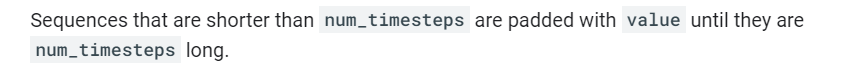

In [ ]:
# Create attention masks
test_attention_masks = []
# 각 트윗마다...
for sent in test_input_ids:
    # Attention Mask 만들기
    #  - token_id가 0이라면, 패딩이다. 마스크값에 0을 주고,
    #  - token_id가 >0이라면, 의미 있는 토큰이므로 마스크값에 1 주기!
    seq_mask = [int(token_id>0) for token_id in sent]

    test_attention_masks.append(seq_mask)

In [ ]:
# torch.tensor로 변환
test_inputs = torch.tensor(test_input_ids)
test_masks = torch.tensor(test_attention_masks)

#### *** 여기서 Test_sampler을 randomsampler이 아니라 sequentialsampler로 고쳐 주니까 학습이 비로소 잘 이루어짐 ***
validation data와 test data는 dataloader에 들어가는 sampler를 구성함에 있어 train data(RandomSampler)와는 달리 SequentialSampler을 사용한다.)

In [ ]:
# DataLoader 만들기
# BERT를 fine-tuning할 때 배치 사이즈 16 혹은 32가 권장된다. 
batch_size = 32

# test_set을 위한 Data_loader 만들기
test_data= TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size = batch_size)

<img src= attachment:a1e7845b-0018-4f04-835b-23f62087b382.png width = 80%>
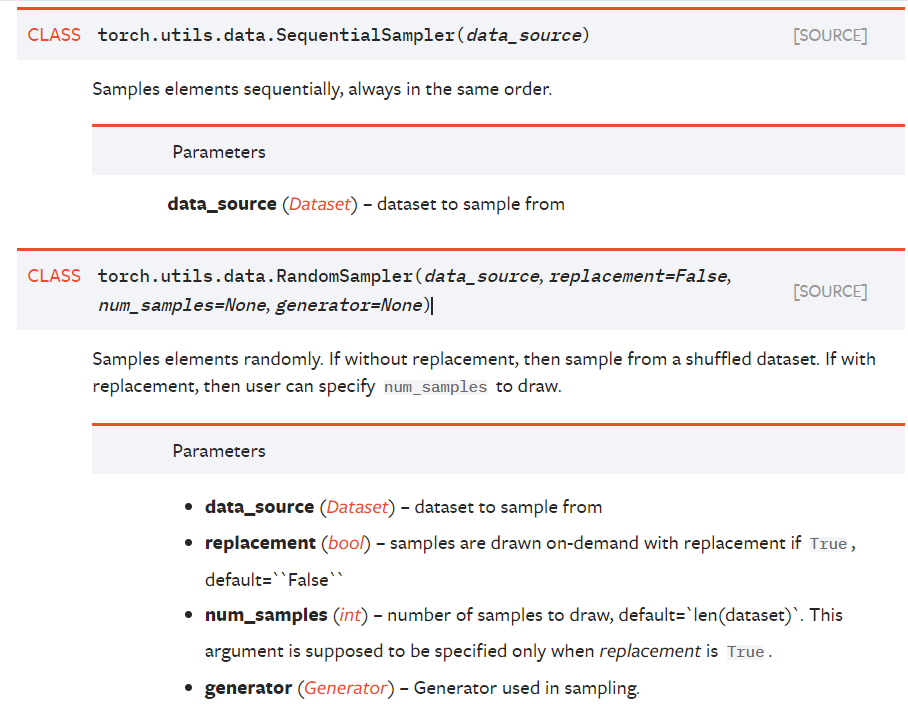

# Evaluate on Test Set

In [ ]:
# Fine-Tuned 모델로 테스트 셋에 대한 예측 수행
print('Predicting labels for {:,} test tweets...'.format(len(test_inputs)))

# 모델을 evaluation모드로 설정
model.eval()

# 변수들 추적
predictions = []
pred_explicit = []

# 경과 시간 확인하기 위해 예측 전 시간 측정
t0 = time.time()

# 예측
for (step, batch) in enumerate(test_dataloader):
    # GPU에 Batch 추가
    batch = tuple(t.to(device) for t in batch)

    # 100배치당 진행 상황 보고
    if step % 100 == 0 and not step == 0:
        # 경과한 시간 측정
        elapsed = format_time(time.time() - t0)
        # 진행 상황 보고
        print(' Batch {:>5,} of  {:>5,}. Elapsed: {:}'.format(step, len(test_dataloader), elapsed))

    # dataloader의 (바로 위에서 구성된)batch에서 input들 꺼내기
    b_input_ids, b_input_mask = batch

    # 평가 단계이므로 모델에게 기울기를 계산하거나 저장하지 않도록 명령
    with torch.no_grad():
        # 순전파 수행: 예측 로짓값 계산
        outputs = model(b_input_ids,
                        token_type_ids = None,
                        attention_mask = b_input_mask)
        
    loss_logits = outputs[0]

    # 손실 로짓값을 cpu에 옮기기
    logits = loss_logits.detach().cpu().numpy()

    # 모델이 내놓은 예측값 저장
    predictions.append(logits)

    # 예측값(logits)은 [재난 트윗이 아닐 확률을 나타내는 로짓값, 재난 트윗일 확률인 로짓값]으로 산출됨.
    # 두 값을 비교하여 더 큰 확률을 지니는 항목를(0 또는 1) 산출하여 pred_explicit 리스트에 추가
    for i in range(len(logits)):
        if logits[i][0] > logits[i][1]:
            pred_explicit.append(0)
        else:
            pred_explicit.append(1)

print('   Done.')

In [ ]:
# 배치 단위로 주어진 예측값들 concatenate
predictions = np.concatenate(predictions, axis = 0)

In [ ]:
# 예측된 결과 조금 살펴보기
predictions[0:10]

In [ ]:
# pred_explicit 구성하는 코드가 test_df의 모든 tweet에 대한 예측값을 0 또는 1로 변환했는지 확인
len(pred_explicit)

In [ ]:
# pred_explicit 리스트 데이터 프레임으로 만든 뒤 sample_submission에 (예측)값들 넣기
sample_submission['target'] = pred_explicit
sample_submission[:10]

In [ ]:
sample_submission

In [ ]:
# 예측 정확도 실제 test tweet 보며 직접 가늠해보기
test_df[:10]

In [ ]:
# sample_submission csv파일로 저장
sample_submission.to_csv('/content/drive/MyDrive/Dacon_Data/[Kaggle]Disaster_Tweets/submission.csv', index = False)